# Recommendation algorithm for GI50
This NCI60 data gives an insight to effect of a chemical on cancer.
Cancer is not one disease but a collection of every possible cell in your body growing uncontrolled.
For this reason NCI60 has multiple different cell lines (column CELL_NAME).

I have here the GI50 data of the NCI60 project
GI50: concentration to stop growth with 50%. column "AVERAGE" is the average concentration needed.

This data is loaded into the graph database with [this schema](https://medium.com/p/8e9aafbb5788).

![schema](https://miro.medium.com/max/1400/0*OBTXGfA2Stl-MIsZ)

In [1]:
import pandas as pd
from os.path import join as path_join
import numpy as np
import json

In [2]:
# Set up connection with the graph database
import json

from py2neo import Graph

with open("config.json") as f:
    config = json.load(f)

neo4j_url = config.get("neo4jUrl", "bolt://localhost:7687")
user = config.get("user", "neo4j")
pswd = config.get("pswd", "password")
graph = Graph(neo4j_url, auth=(user, pswd))

Using the csv itself as reverence.
It is not perfect because some cell lines of chemicals could not be loaded.

In [3]:
gi50 = pd.read_csv(path_join("data", "GI50.csv"))
print(gi50.shape)
gi50.head()

(4585048, 14)


,RELEASE_DATE,EXPID,PREFIX,NSC,CONCENTRATION_UNIT,LOG_HI_CONCENTRATION,PANEL_NUMBER,CELL_NUMBER,PANEL_NAME,CELL_NAME,PANEL_CODE,COUNT,AVERAGE,STDDEV
0,20210223,0001MD02,S,123127,M,-4.6021,1,1,Non-Small Cell Lung Cancer,NCI-H23,LNS,1,-7.1391,0.0
1,20210223,0001MD02,S,123127,M,-4.6021,10,14,Melanoma,M14,MEL,1,-7.0520,0.0
2,20210223,0001MD02,S,123127,M,-4.6021,12,5,CNS Cancer,SNB-75,CNS,1,-7.1380,0.0
3,20210223,0001MD02,S,123127,M,-4.6021,4,2,Colon Cancer,HCC-2998,COL,1,-6.9426,0.0
4,20210223,0001MD02,S,123127,M,-4.6021,5,5,Breast Cancer,MDA-MB-231/ATCC,BRE,1,-6.4485,0.0


In [4]:
# Load all cell lines that are in the graph database
with open("cellline_nci60_to_chembl.json", "r") as fp:
    cell_lines_json = json.load(fp)

cell_lines = [i for i in cell_lines_json if cell_lines_json[i]]

filtered_gi50 = gi50.loc[gi50["CELL_NAME"].isin(cell_lines)]

Creating a pivot table. Where every value is the average GI50 value of the combination cell line (row) and chemical (column). This makes the data easier to work with.

In [5]:
correlation = pd.pivot_table(filtered_gi50, values='AVERAGE', index=['CELL_NAME'],
                    columns=['NSC'], aggfunc=np.mean)
correlation.head()

NSC,1,17,26,89,112,171,185,186,196,197,...,836824,836941,836942,837081,837082,837396,837397,837398,837892,837893
CELL_NAME,,,,,,,,,,,,,,,,,,,,,
786-0,-4.716867,-5.557233,-5.4265,-4.700050,-6.4911,-4.0,-7.4287,-4.609967,-5.1022,-5.5461,...,-5.4324,-5.3468,-4.0,-4.8286,-5.1042,-6.69690,-5.5047,-6.56690,-4.301,-5.6072
A-172/H.Fine,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.230500,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A-204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A498,-4.363500,-4.664067,NaN,-4.144533,-6.1375,-4.0,NaN,-5.458580,-4.9329,-4.8278,...,-5.3284,-4.0000,-4.0,-4.8123,-4.8738,-5.75485,-5.4407,-6.79295,-4.301,-5.6273


# Distance between 2 chemicals
The difference in how 2 chemicals react to the same cell lines gives us an idea how similar those 2 chemicals are. If we take the average of these differences a distance between the two chemicals. Where 0 means the chemicals are the same, and infinite means they could not be more different.
Below we use pandas to get the difference between NSC 19893 and NSC 713724.

In [6]:
all_diffs_pd = np.abs(correlation[19893] - correlation[713724])
print(f"Avg diff {all_diffs_pd.mean()}, num cell lines used {sum(all_diffs_pd.notna())}")

Avg diff 0.5365136610125857, num cell lines used 59


We can do the same in a graph database. However the we have a few more steps. First we need pubChemSynId of the NSC numbers. We can just looks these up.
Now we need to find all condition that measure GI50, use NSC 19893 (176dde90cc9dd83eed129de11b203b03), and find all cell lines used in those conditions.
Per cell line we take the average GI50 of all conditions.

After that find out if these cell lines have a condition measuring GI50 and using NSC 713724 (1d75798754df81c782e805287ff7ef83). We take the average per cell line again.

These 2 steps create the same as the pivoted array and selecting the 2 columns.

Lastly we substrate the two values from each other and average those abs difference to get our distance metric.

The value does differ slightly compared to the pandas method because of a small difference between the what is loaded into graph database and what is in the CSV

In [7]:
response = graph.run(
    """
    MATCH (org_chem:Synonym {pubChemSynId: "176dde90cc9dd83eed129de11b203b03"})
    MATCH (gi50:Measurement {name: "GI50"})

    MATCH (cell:CellLine)<-[:USES]-(c:Condition)-[:USES]->(org_chem)
    MATCH (c)-[m:MEASURES]->(gi50)
    WITH DISTINCT cell, avg(toFloat(m.value)) as values1, gi50

    CALL {
        WITH cell, gi50, values1
        MATCH (chem:Synonym)
        WHERE chem.pubChemSynId IN ["1d75798754df81c782e805287ff7ef83"]
        MATCH (cell)<-[:USES]-(c:Condition)-[:USES]->(chem)
        MATCH (c)-[m2:MEASURES]->(gi50)
        RETURN DISTINCT cell as cell2, abs(avg(toFloat(m2.value)) - values1) as distance,  chem
    }

    RETURN DISTINCT chem.name, avg(distance) as dist, count(distance) as num_cells
    """
).data()

all_diffs_neo = {}
r = response[0]
print(f"Avg diff {r['dist']}, num cell lines used {r['num_cells']}")

Avg diff 0.5365163605299944, num cell lines used 59


The difference between the 2 approaches is very small. I will ignore it for this research but did not want to hide it.

In [8]:
all_diffs_pd.mean() - r['dist']

-2.6995174087218743e-06

# Distance to all other chemicals
If we repeat the distance calculation from above we can do it towards all other chemicals. Making it a collaborative filtering. Doing this in both the CSV and Cypher we find the top 9 of the top 10 is the same. Both revealing that NSC 19893 looks to most like NSC 19893...

In [9]:
response = graph.run(
    """
    MATCH (org_chem:Synonym {pubChemSynId: "176dde90cc9dd83eed129de11b203b03"})
    MATCH (gi50:Measurement {name: "GI50"})

    MATCH (cell:CellLine)<-[:USES]-(c:Condition)-[:USES]->(org_chem)
    MATCH (c)-[m:MEASURES]->(gi50)
    WITH DISTINCT cell, avg(toFloat(m.value)) as values1, org_chem, gi50

    CALL {
        WITH cell, gi50, values1
        MATCH (cell)<-[:USES]-(c:Condition)-[:USES]->(chem:Synonym)
        MATCH (c)-[m2:MEASURES]->(gi50)
        RETURN DISTINCT cell as cell2, abs(avg(toFloat(m2.value)) - values1) as distance,  chem
    }

    RETURN DISTINCT chem.name, avg(distance) as avg_dist, count(distance) as num_cell ORDER BY avg_dist limit 25
    """
).data()
for r in response:
    print(r)

{'chem.name': 'nsc19893', 'avg_dist': 3.4386907735687276e-15, 'num_cell': 74}
{'chem.name': 'nsc-684405', 'avg_dist': 0.3018711839192636, 'num_cell': 60}
{'chem.name': 'nsc-361605', 'avg_dist': 0.3177947681672626, 'num_cell': 49}
{'chem.name': 'nsc-628083', 'avg_dist': 0.33545731366684184, 'num_cell': 60}
{'chem.name': 'nsc-618093', 'avg_dist': 0.3451951788719919, 'num_cell': 60}
{'chem.name': 'nsc-613493', 'avg_dist': 0.35390246003660175, 'num_cell': 50}
{'chem.name': 'nsc628537', 'avg_dist': 0.3781293960020346, 'num_cell': 46}
{'chem.name': 'nsc-785594', 'avg_dist': 0.3781573653571885, 'num_cell': 60}
{'chem.name': 'nsc-628081', 'avg_dist': 0.39269238426318265, 'num_cell': 60}
{'chem.name': 'nsc-625429', 'avg_dist': 0.4004440031716282, 'num_cell': 48}
{'chem.name': 'nsc-710905', 'avg_dist': 0.4049072484843805, 'num_cell': 56}
{'chem.name': 'nsc-621349', 'avg_dist': 0.4075924911847263, 'num_cell': 44}
{'chem.name': 'nsc7833', 'avg_dist': 0.4139957489909666, 'num_cell': 46}
{'chem.name

In [10]:
all_diffs_np = np.abs(np.expand_dims(correlation[19893].to_numpy(), 1) - correlation.to_numpy())
all_diffs_2_19893 = []
for nsc, mean in zip(correlation.columns, np.nanmean(all_diffs_np, 0)):
    all_diffs_2_19893.append([mean, nsc])

sorted(all_diffs_2_19893, key=lambda x: x[0])[:10]

[[0.0, 19893],
 [0.30187383844471566, 684405],
 [0.3177915177279329, 361605],
 [0.3354599681922921, 628083],
 [0.3451978333974429, 618093],
 [0.35390564546714137, 613493],
 [0.37812593357753244, 628537],
 [0.37815471083173713, 785594],
 [0.39269503878863327, 628081],
 [0.3973611393190983, 80870]]

In order to use the filter for prediction we need to modify it a little bit. If we are interested in NSC 19893 effect on cell line 'HCT-15' we need to 2 things.
1) Remove HCT-15 from the collaborative filtering
2) Only select chemicals with an known reaction to HCT-15
3) (Extra): Remove NSC 19893 from the predicted chemicals

In [11]:
# Example of nsc-625429 that has NO condition with HCT-15
response = graph.run(
    """
    MATCH (chem:Synonym {pubChemSynId: '30c187a8de84997a02fc1f9eb7eea01b'})
    MATCH (cell:CellLine {name: "HCT-15"})
    OPTIONAL MATCH (cell)<-[:USES]-(c:Condition)-[:USES]->(chem)
    RETURN chem.name, cell.name, c
    """
).data()
for r in response:
    print(r)

{'chem.name': 'nsc-625429', 'cell.name': 'HCT-15', 'c': None}


In [12]:
response = graph.run(
    """
    MATCH (org_chem:Synonym {pubChemSynId: "176dde90cc9dd83eed129de11b203b03"})
    MATCH (the_cell:CellLine {name: "HCT-15"})
    MATCH (gi50:Measurement {name: "GI50"})

    MATCH (cell:CellLine)<-[:USES]-(c:Condition)-[:USES]->(org_chem)
    WHERE cell <> the_cell // 1
    MATCH (c)-[m:MEASURES]->(gi50)
    WITH DISTINCT cell, avg(toFloat(m.value)) as values1, org_chem, gi50, the_cell
    CALL {
        WITH cell, gi50, values1, org_chem, the_cell
        MATCH (cell)<-[:USES]-(c:Condition)-[:USES]->(chem:Synonym)
        WHERE exists((chem)<-[:USES]-(:Condition)-[:USES]->(the_cell)) AND chem <> org_chem // 2 & 3
        MATCH (c)-[m2:MEASURES]->(gi50)
        RETURN DISTINCT cell as cell2, abs(avg(toFloat(m2.value)) - values1) as distance, chem
    }

    WITH DISTINCT chem, avg(distance) as avg_dist, count(distance) as num_cell 
    RETURN chem.name, avg_dist, num_cell ORDER BY avg_dist limit 25
    """
).data()
for r in response:
    print(r)

{'chem.name': 'nsc-684405', 'avg_dist': 0.30413082478114195, 'num_cell': 59}
{'chem.name': 'nsc-361605', 'avg_dist': 0.31986023473182124, 'num_cell': 48}
{'chem.name': 'nsc-628083', 'avg_dist': 0.33290434655834006, 'num_cell': 59}
{'chem.name': 'nsc-618093', 'avg_dist': 0.34773573490256054, 'num_cell': 59}
{'chem.name': 'nsc-613493', 'avg_dist': 0.35006572711758455, 'num_cell': 49}
{'chem.name': 'nsc628537', 'avg_dist': 0.3772233298450033, 'num_cell': 45}
{'chem.name': 'nsc-785594', 'avg_dist': 0.3796167720061503, 'num_cell': 59}
{'chem.name': 'nsc-628081', 'avg_dist': 0.3897650963173308, 'num_cell': 59}
{'chem.name': 'nsc-710905', 'avg_dist': 0.39922370076467034, 'num_cell': 55}
{'chem.name': 'nsc-651242', 'avg_dist': 0.41289216854840305, 'num_cell': 45}
{'chem.name': 'nsc-624425', 'avg_dist': 0.4140202228771283, 'num_cell': 38}
{'chem.name': 'nsc7833', 'avg_dist': 0.420691262814509, 'num_cell': 45}
{'chem.name': 'nsc-318800', 'avg_dist': 0.4212977120971919, 'num_cell': 59}
{'chem.nam

In [25]:
response = graph.run(
    """
    MATCH (the_cell:CellLine {name: "HCT-15"})
    MATCH (org_chem:Synonym {pubChemSynId: "176dde90cc9dd83eed129de11b203b03"})

    CALL {
        WITH the_cell, org_chem
        
        MATCH (gi50:Measurement {name: "GI50"})

        MATCH (cell:CellLine)<-[:USES]-(c:Condition)-[:USES]->(org_chem)
        WHERE cell <> the_cell // 1
        MATCH (c)-[m:MEASURES]->(gi50)
        WITH DISTINCT cell, avg(toFloat(m.value)) as values1, org_chem, gi50, the_cell
        CALL {
            WITH cell, gi50, values1, org_chem, the_cell
            MATCH (cell)<-[:USES]-(c:Condition)-[:USES]->(chem:Synonym)
            WHERE exists((chem)<-[:USES]-(:Condition)-[:USES]->(the_cell)) AND chem <> org_chem // 2 & 3
            MATCH (c)-[m2:MEASURES]->(gi50)
            RETURN DISTINCT cell as cell2, abs(avg(toFloat(m2.value)) - values1) as distance, chem
        }

        WITH DISTINCT chem, avg(distance) as avg_dist, count(distance) as num_cell 
        RETURN chem, avg_dist, num_cell ORDER BY avg_dist limit 25
    }
    MATCH (the_cell)<-[:USES]-(c:Condition)-[:USES]->(chem)
    MATCH (c)-[m3:MEASURES]->(gi50)
    
    WITH DISTINCT chem, avg(toFloat(m3.value)) as avg_value, org_chem, the_cell
    RETURN DISTINCT the_cell.name, avg(avg_value), org_chem
    """
).data()
for r in response:
    print(r)

{'the_cell.name': 'HCT-15', 'avg(avg_value)': -4.8078468, 'org_chem': Node('Synonym', name='nsc19893', pubChemSynId='176dde90cc9dd83eed129de11b203b03')}


In [18]:
response = graph.run(
    """
    MATCH (org_chem:Synonym {pubChemSynId: "176dde90cc9dd83eed129de11b203b03"})
    MATCH (the_cell:CellLine {name: "HCT-15"})
    MATCH (gi50:Measurement {name: "GI50"})

    MATCH (the_cell)<-[:USES]-(c:Condition)-[:USES]->(org_chem)
    MATCH (c)-[m:MEASURES]->(gi50)

    RETURN DISTINCT the_cell.name, avg(toFloat(m.value)) as value, count(m) as number_measurements
    """
).data()
for r in response:
    print(r)

{'the_cell.name': 'HCT-15', 'value': -5.243602373068445, 'number_measurements': 1812}


# Validation

<AxesSubplot:>

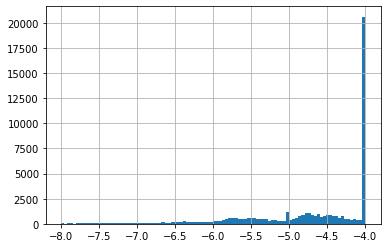

In [32]:
all_cell_values = correlation.loc["HCT-15"]
all_cell_values.loc[(all_cell_values <= -4) & (all_cell_values > -8)].hist(bins=100)

<AxesSubplot:>

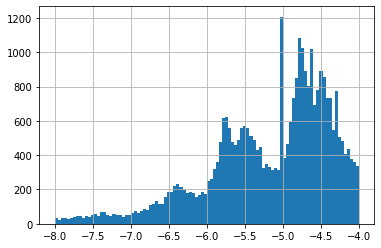

In [33]:
all_cell_values = correlation.loc["HCT-15"]
all_cell_values.loc[(all_cell_values < -4) & (all_cell_values > -8)].hist(bins=100)